In [3]:
import pandas as pd

from dotenv import load_dotenv
import os
from groq import Groq

import re
from tqdm.auto import tqdm

In [4]:
df = pd.read_csv('../data/baby_recipes_cleaned.csv', sep = ';')
documents = df.to_dict(orient='records')

In [5]:
documents[0]

{'id': 1,
 'dish_name': 'Sweet Potato Purée',
 'baby_age': '6-8 months',
 'iron_rich': 'No',
 'allergen': 'Dairy',
 'ingredients': 'sweet potato, water or breastmilk/formula',
 'cooking_time': 15,
 'recipe': 'Wash and prep ingredients: sweet potato, water or breastmilk/formula. Steam or gently simmer vegetables/fruit until fork-tender. Blend with a splash of cooking water or breastmilk/formula until smooth. Cool before serving. Store in the fridge up to 2 days or freeze portions up to 1 month.',
 'texture': 'Purée',
 'meal_type': 'Breakfast',
 'calories': 160,
 'preparation_difficulty': 'Easy'}

In [6]:
ground_truth = pd.read_csv('../data/ground-truth-data.csv')
ground_truth = ground_truth.to_dict(orient='records')
ground_truth[0]

{'id': 1, 'question': 'Does this recipe contain any allergens?'}

In [7]:
#load_dotenv()

#groq_client = Groq(api_key=os.getenv("GROQ_API_KEY"))

# 1. Vector Search

In [8]:
from qdrant_client import QdrantClient, models

In [9]:
qd_client = QdrantClient("http://localhost:6333")

In [10]:
model = 'BAAI/bge-small-en'
EMBEDDING_DIMENSIONALITY = 384
collection_name = "recipe_database"

In [11]:
qd_client.delete_collection(collection_name=collection_name)

True

In [12]:
qd_client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=models.Distance.COSINE
    )
)

True

In [13]:
qd_client.create_payload_index(
    collection_name=collection_name,
    field_name="id",
    field_schema="keyword"
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [14]:
points = []

for i, doc in enumerate(documents):
    text = ' '.join(str(doc.get(field, "")) for field in df.columns if field != "id")

    vector = models.Document(text=text, model=model)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [15]:
qd_client.upsert(
    collection_name=collection_name,
    points=points
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [16]:
def vector_search(question):
    
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

# 2. Minsearch

In [17]:
import minsearch

index = minsearch.Index(
    text_fields=['dish_name', 'baby_age', 'iron_rich', 'allergen', 'ingredients',
                 'recipe', 'texture', 'meal_type', 'preparation_difficulty'],
    keyword_fields=["id", 'cooking_time', 'calories']
)

index.fit(documents)

In [18]:
def minsearch_search(query):

    results = index.search(
        query=query,
        num_results=5
    )

    return results

# 3. Elastic search

In [19]:
df.columns

Index(['id', 'dish_name', 'baby_age', 'iron_rich', 'allergen', 'ingredients',
       'cooking_time', 'recipe', 'texture', 'meal_type', 'calories',
       'preparation_difficulty'],
      dtype='object')

In [20]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "dish_name": {"type": "text"},
            "baby_age": {"type": "text"},
            "iron_rich": {"type": "text"},
            "allergen": {"type": "keyword"},
            "ingredients": {"type": "text"},
            "recipe": {"type": "text"},
            "texture": {"type": "text"},
            "meal_type": {"type": "text"},
            "preparation_difficulty": {"type": "text"},
            "cooking_time": {"type": "keyword"},
            "calories": {"type": "keyword"},
            "id": {"type": "keyword"},
        }
    }
}

index_name = "recipes"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'recipes'})

In [21]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
def elastic_search(query):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["dish_name", "baby_age", "iron_rich", "allergen", "ingredients",
                                   "recipe", "texture", "meal_type", "preparation_difficulty"],
                        "type": "best_fields"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

# 4. Evaluation
## 4.1 Retrieval Evaluation

In [23]:
ground_truth[0]

{'id': 1, 'question': 'Does this recipe contain any allergens?'}

In [24]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [25]:
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [26]:
def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['id']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [27]:
evaluate(ground_truth, lambda q: vector_search(q['question']))

  0%|          | 0/2461 [00:00<?, ?it/s]

{'hit_rate': 0.3063795205201138, 'mrr': 0.17836922660165172}

In [28]:
evaluate(ground_truth, lambda q: minsearch_search(q['question']))

  0%|          | 0/2461 [00:00<?, ?it/s]

{'hit_rate': 0.2974400650142219, 'mrr': 0.1852431261005002}

In [29]:
evaluate(ground_truth, lambda q: elastic_search(q['question']))

  0%|          | 0/2461 [00:00<?, ?it/s]

{'hit_rate': 0.2901259650548558, 'mrr': 0.18045509955302644}

## 4.2 LLM Evaluation

In [21]:
from dotenv import load_dotenv
import os
from groq import Groq

In [22]:
load_dotenv()

groq_client = Groq(api_key=os.getenv("GROQ_API_KEY"))

In [23]:
prompt_template = """
You are a helpful AI food assistant. Answer the QUESTION using only the information in CONTEXT. 
If the answer is not in CONTEXT, say you don't know.

Provide concise, factual answers with a recipe per dish. If multiple dishes match, summarize clearly.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

entry_template = """
'dish_name': '{dish_name}',
'baby_age' : {baby_age},
'iron_rich': {iron_rich},
'allergen': {allergen},
'ingredients': '{ingredients}',
'cooking_time': {cooking_time},
'texture': '{texture}',
'meal_type': '{meal_type}',
'calories': {calories},
'preparation_difficulty': '{preparation_difficulty}',
'recipe': '{recipe}'
""".strip()


def build_prompt(query, search_results):

    context = ""

    for doc in search_results:
        context = context + entry_template.format(**doc) + "\n\n"

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt


In [24]:
def llm(prompt, model = 'qwen/qwen3-32b'):
    response = groq_client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    final_answer = response.choices[0].message.content

    return re.sub(r"<think>.*?</think>\s*", "", final_answer, flags=re.DOTALL).strip()

In [25]:
# previously: rag(query: str) -> str
#def rag(query: dict, model='qwen/qwen3-32b') -> str:
def rag(query, model='qwen/qwen3-32b'):
    search_results = vector_search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt, model=model)
    return answer

In [26]:
answers = {}

In [27]:
doc_idx = {d['id']: d for d in documents}

In [32]:
ground_truth

[{'id': 1, 'question': 'Does this recipe contain any allergens?'},
 {'id': 1, 'question': 'Is this dish considered iron-rich for babies?'},
 {'id': 1,
  'question': 'Can this purée be served warm, or must it be cooled first?'},
 {'id': 1, 'question': 'How long can this purée be stored in the freezer?'},
 {'id': 1,
  'question': 'Is this recipe suitable for a baby younger than 6 months?'},
 {'id': 2, 'question': 'Is Carrot Purée suitable for a 6-month-old baby?'},
 {'id': 2, 'question': "Why isn't this recipe labeled as iron-rich?"},
 {'id': 2, 'question': 'Does the dish contain dairy as an allergen?'},
 {'id': 2, 'question': 'How many calories does this baby food provide?'},
 {'id': 2, 'question': 'Can the purée be frozen for longer storage?'},
 {'id': 3,
  'question': 'Is this pumpkin purée recipe suitable for a 6-month-old baby or only for older infants?'},
 {'id': 3,
  'question': 'Does this dish contain any allergens that parents should be cautious about?'},
 {'id': 3,
  'question'

In [35]:
df_sample = pd.DataFrame(ground_truth).sample(200, random_state=42)
df_sample = df_sample.to_dict(orient='records')

In [38]:
for i, rec in enumerate(tqdm(df_sample)):
    if i in answers:
        continue
    #print(rec)
    answer_llm = rag(rec['question'])
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_orig = (original_doc['dish_name'] + ". " + original_doc['baby_age'] + "." + original_doc['iron_rich'] + 
                   original_doc['allergen'] + ". " + original_doc['ingredients'] + "." + original_doc['recipe'] +
                   original_doc['texture'] + ". " + original_doc['meal_type'] + ". " + original_doc['preparation_difficulty']).strip()

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question']
    }

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
df_groq = pd.DataFrame(answers).T
df_groq

,answer_llm,answer_orig,document,question
0,"Yes, the recipes contain **Egg** and **Gluten*...",Sweet Potato Purée. 6-8 months.NoDairy. sweet ...,1,Does this recipe contain any allergens?
1,"Yes, all the listed dishes are considered iron...",Sweet Potato Purée. 6-8 months.NoDairy. sweet ...,1,Is this dish considered iron-rich for babies?
2,All purées listed must be cooled before servin...,Sweet Potato Purée. 6-8 months.NoDairy. sweet ...,1,"Can this purée be served warm, or must it be c..."
3,The purée can be stored in the freezer for up ...,Sweet Potato Purée. 6-8 months.NoDairy. sweet ...,1,How long can this purée be stored in the freezer?
4,"No, none of the recipes provided are suitable ...",Sweet Potato Purée. 6-8 months.NoDairy. sweet ...,1,Is this recipe suitable for a baby younger tha...
...,...,...,...,...
195,The recipes provided are typically served for ...,"Pea Purée (Steamed). 7-10 months.Nono. peas, w...",424,What meal is this recipe typically served for?
196,The Tofu & Broccoli Purée contains **soy** as ...,Tofu & Broccoli Purée (Family Style). 7-10 mon...,101,Does the Tofu & Broccoli Purée contain any com...
197,The CONTEXT does not specify gluten-free pasta...,Beef & Veggie Bolognese (Hidden Veg). 12-18 mo...,150,Can I substitute the pasta with a gluten-free ...
198,The chickpeas and rice should be prepared as f...,Mild Chickpea Curry with Rice (Steamed). 12-18...,268,How should the chickpeas and rice be prepared ...


In [40]:
df_groq.to_csv('../data/answers_groq.csv', index=False)

### Cosine similarity

In [53]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\kabal\Documents\study\llm-zoomcamp\baby_food_guide\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kabal\.cache\huggingface\hub\models--sentence-transformers--multi-qa-MiniLM-L6-cos-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [68]:
answers_orig = df_groq['answer_orig'].astype(str).tolist()
answers_llm = df_groq['answer_llm'].astype(str).tolist()

v_orig = model.encode(answers_orig)
v_llm = model.encode(answers_llm)

similarity = (v_llm * v_orig).sum(axis=1)

In [70]:
df_groq['cosine'] = similarity
df_groq['cosine'].describe()

count    200.000000
mean       0.556133
std        0.238678
min        0.110956
25%        0.339673
50%        0.554388
75%        0.790231
max        0.925639
Name: cosine, dtype: float64

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

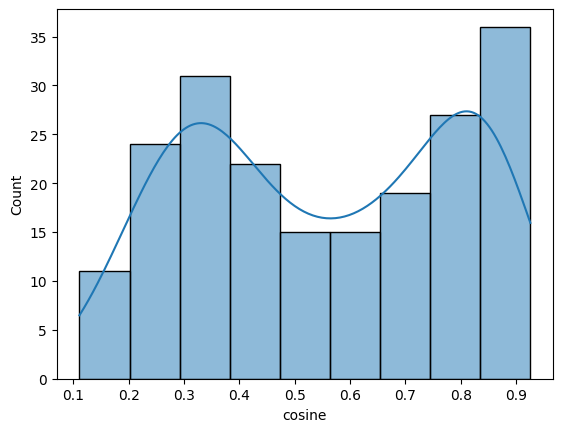

In [73]:
sns.histplot(df_groq['cosine'], kde=True)
plt.show()